In [8]:
import numpy as np
import pandas as pd
from copy import copy
import sys
sys.path.append('/home/ndsviriden/MinMax94/src/utils') 
from constants import data_directory, MmxColumns
from interpolation import interpolate_mmx, create_patterns
from converters import convert_raw_to_mmx
from preprocessing import get_clean_data
from loaders import load_mm94_stations, select_mm94_features
from geographical import find_nearest_wmo_station, add_solar_angles, add_coordinates, add_road_id
from sklearn.ensemble import IsolationForest
from score import get_labels
from score import calc_precision, calc_recall
import gc
from tqdm import tqdm_notebook
from functools import reduce

In [9]:
# available for test:
# 20921, 20916, 20761, 20755, 20754, 20743, 20717, 20323
# 1921, 1911, 1899, 1831, 1826, 1813, 1808, 704, 702, 635, 628, 626, 615, 593,
# 456, 454, 435, 432, 411, 401, 309, 308, 305, 302, 239, 228, 231, 200, 158, 150, 
# 126, 119, 118, 117, 116, 115, 114, 113

# available for experiments:
# 114, 115, 116, 117, 119, 302, 303, 304, 305, 306, 307,
# 308, 309, 393, 442, 470, 471, 472, 502, 503, 504, 505,
# 506, 507, 508, 511, 512, 513, 514, 515, 516, 591, 592,
# 593, 596, 597, 599, 612, 613, 614, 615, 616, 617, 618,
# 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629,
# 836, 837, 838, 839, 862, 863, 874, 875, 888, 1820, 1832,
# 1833, 1834, 1835, 1836, 1838, 1896, 1899, 4007

# small outliers:
# 114, 119, 302, 303, 442, 511, 512, 514, 629, 838, 839

# big bugs
# 307, 393, 503, 504, 505, 516, 619, 1838, 1896 -- big bugs

## Loading data

In [10]:
%%time
test_station_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 
                   511, 516, 1838, 1896]


train_station_id = [113, 115, 116, 118, 126, 150, 152, 200, 223, 228, 
                    239, 305, 308, 309, 401, 411, 432, 435, 454, 456, 
                    593, 628, 1831, 1899, 1911, 1921, 4007, 20323, 20717, 20743, 
                    20754, 20755, 20761, 20916, 20921]

raw = load_mm94_stations(train_station_id + test_station_id)
raw = select_mm94_features(raw, ['t_air', 't_road', 't_underroad', 'pressure', 'dampness'])

mmx_rwis = convert_raw_to_mmx(raw)
mmx_rwis_interpolated = interpolate_mmx(mmx_rwis)
data = create_patterns(mmx_rwis_interpolated)

data['data_solar_azimuth'], data['data_solar_altitude'] = add_solar_angles(data)
data['data_latitude'], data['data_longitude'] = add_coordinates(data)
data['data_road'] = add_road_id(data)
data = data.dropna(subset=('data_t_road', ))

del data[MmxColumns.ID_AIR_TEMPERATURE], data[MmxColumns.ID_UNDERGROUND_TEMPERATURE], \
    data[MmxColumns.ID_PRESSURE], data[MmxColumns.ID_HUMIDITY]

train = data[data['station_id'].isin(train_station_id)]
train = train.reset_index(drop=True)
train_clean = get_clean_data(train)

test = data[data['station_id'].isin(test_station_id)]
test = test.reset_index(drop=True)
test['label_true'] = get_labels(test, labels_type='true')

del data, raw, mmx_rwis, mmx_rwis_interpolated
gc.collect()

/home/ndsviriden/MinMax94/src/utils/geographical.py:65: RuntimeWarning: invalid value encountered in arccos
  solar_azimuth = np.arccos(cos_az) * np.sign(h_rad)


CPU times: user 1min 45s, sys: 10.8 s, total: 1min 56s
Wall time: 1min 58s


## Feature selection

In [11]:
%%time

from preprocessing import create_feature_df

point = pd.Timestamp(2015, 6, 1)

time = 0
lag_list=(1, 2)
diff_list=((1, 2), )
post_process = False
regression_mode = False
variables = ['data_t_road', 'data_t_air', 'data_t_underroad']

df_train = create_feature_df(train_clean[train_clean['date_time_utc'] < point], 
                             winter_period=False, time=time, lag_list=lag_list,
                             diff_list=diff_list, post_process=post_process, variables=variables)
df_valid = create_feature_df(train_clean[train_clean['date_time_utc'] >= point], 
                             winter_period=False, time=time, lag_list=lag_list,
                             diff_list=diff_list, post_process=post_process, variables=variables)
df_test = create_feature_df(test, 
                            winter_period=False, time=time, lag_list=lag_list,
                            diff_list=diff_list, post_process=post_process, variables=variables)

features = [col for col in df_train if col.startswith('data_')]
target = [col for col in df_train if col.startswith('target_')]

X_train = np.array(df_train[features + target])
#y_train = np.array(df_train[target])

X_valid = np.array(df_valid[features + target])
#y_valid = np.array(df_valid[target])

X_test = np.array(df_test[features + target])
#y_test = np.array(df_test[target].values.reshape(-1, 1))

CPU times: user 4.63 s, sys: 489 ms, total: 5.12 s
Wall time: 5.16 s


In [7]:
from sklearn.preprocessing import normalize

X_test_norm = normalize(X_test, norm='l2', axis=1, copy=True, return_norm=False)

In [12]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=30, contamination=0.0005)
y_true = df_test['label_true']
y_pred = clf.fit_predict(X_test)
df_test['label_predict'] = (1 - y_pred) / 2 

In [6]:
df_test.to_csv('/mnt/HARD/MinMax94/models/results/local_outlier_factor.csv', index=False)

In [7]:
import pickle

pickle.dump(clf, open('/mnt/HARD/MinMax94/models/pickle/local_outlier_factor.pickle', "wb"))

## Recall

In [13]:
predicted_anomalies_ids = set()
window = pd.Timedelta('4h')

st_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 442, 503, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]
for station in st_id:
    df = df_test[df_test['station_id']==station]
    predicted_anomalies = df[df['label_predict']==1]
    for anomaly in predicted_anomalies.iterrows():
        dt = anomaly[1]['date_time_utc']
        locality = df_test[(df_test['date_time_utc'] >= (dt - window)) & 
                       (df_test['date_time_utc'] <= (dt + window))]
        
        predicted_anomalies_ids.update(set(locality.index))

true_anomalies_ids = set(df_test[(df_test['label_true']==1) & (df_test['station_id'].isin(st_id))].index)

tp = set.intersection(true_anomalies_ids, predicted_anomalies_ids)
recall = len(tp) / len(true_anomalies_ids)
recall

0.5358931552587646

## Precision

In [14]:
true_anomalies_ids = set()
window = pd.Timedelta('4h')

st_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 442, 503, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]
for station in st_id:
    df = df_test[df_test['station_id']==station]
    true_anomalies = df[df['label_true']==1]
    for anomaly in true_anomalies.iterrows():
        dt = anomaly[1]['date_time_utc']
        locality = df_test[(df_test['date_time_utc'] >= (dt - window)) & 
                       (df_test['date_time_utc'] <= (dt + window))]
        
        true_anomalies_ids.update(set(locality.index))
        # print(list(locality.index))

predicted_anomalies_ids = set(df_test[((df_test['label_predict']==1) & (df_test['station_id'].isin(st_id)))].index)

tp = set.intersection(true_anomalies_ids, predicted_anomalies_ids)
precision = len(tp) / len(predicted_anomalies_ids)
precision

0.5022026431718062

## Cycle

In [26]:
predicted_anomalies_ids = set()
window = pd.Timedelta('4h')
station_list = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]

for station_id in station_list:
    st_id = [station_id]
    for station in st_id:
        df = df_test[df_test['station_id']==station]
        predicted_anomalies = df[df['label_predict']==1]
        for anomaly in predicted_anomalies.iterrows():
            dt = anomaly[1]['date_time_utc']
            locality = df_test[(df_test['date_time_utc'] >= (dt - window)) & 
                           (df_test['date_time_utc'] <= (dt + window))]

            predicted_anomalies_ids.update(set(locality.index))

    true_anomalies_ids = set(df_test[(df_test['label_true']==1) & (df_test['station_id'].isin(st_id))].index)

    tp = set.intersection(true_anomalies_ids, predicted_anomalies_ids)
    recall = len(tp) / len(true_anomalies_ids)

    true_anomalies_ids = set()
    window = pd.Timedelta('4h')

    for station in st_id:
        df = df_test[df_test['station_id']==station]
        true_anomalies = df[df['label_true']==1]
        for anomaly in true_anomalies.iterrows():
            dt = anomaly[1]['date_time_utc']
            locality = df_test[(df_test['date_time_utc'] >= (dt - window)) & 
                           (df_test['date_time_utc'] <= (dt + window))]

            true_anomalies_ids.update(set(locality.index))
            # print(list(locality.index))

    predicted_anomalies_ids = set(df_test[((df_test['label_predict']==1) & (df_test['station_id'].isin(st_id)))].index)

    tp = set.intersection(true_anomalies_ids, predicted_anomalies_ids)
    precision = len(tp) / len(predicted_anomalies_ids)
    
    print('{0} : R = {1:0.3f}, P = {2:0.3f}'.format(station_id, recall, precision))

114 : R = 0.611, P = 0.324
117 : R = 0.208, P = 0.149
119 : R = 0.788, P = 0.250
302 : R = 0.633, P = 0.700
303 : R = 0.605, P = 0.500
307 : R = 0.102, P = 0.855
393 : R = 0.039, P = 0.571
442 : R = 1.000, P = 0.520
503 : R = 0.129, P = 0.421
504 : R = 0.944, P = 0.556
511 : R = 0.875, P = 0.500
516 : R = 0.302, P = 0.682
1838 : R = 0.903, P = 0.385
1896 : R = 0.174, P = 0.438


## Plot

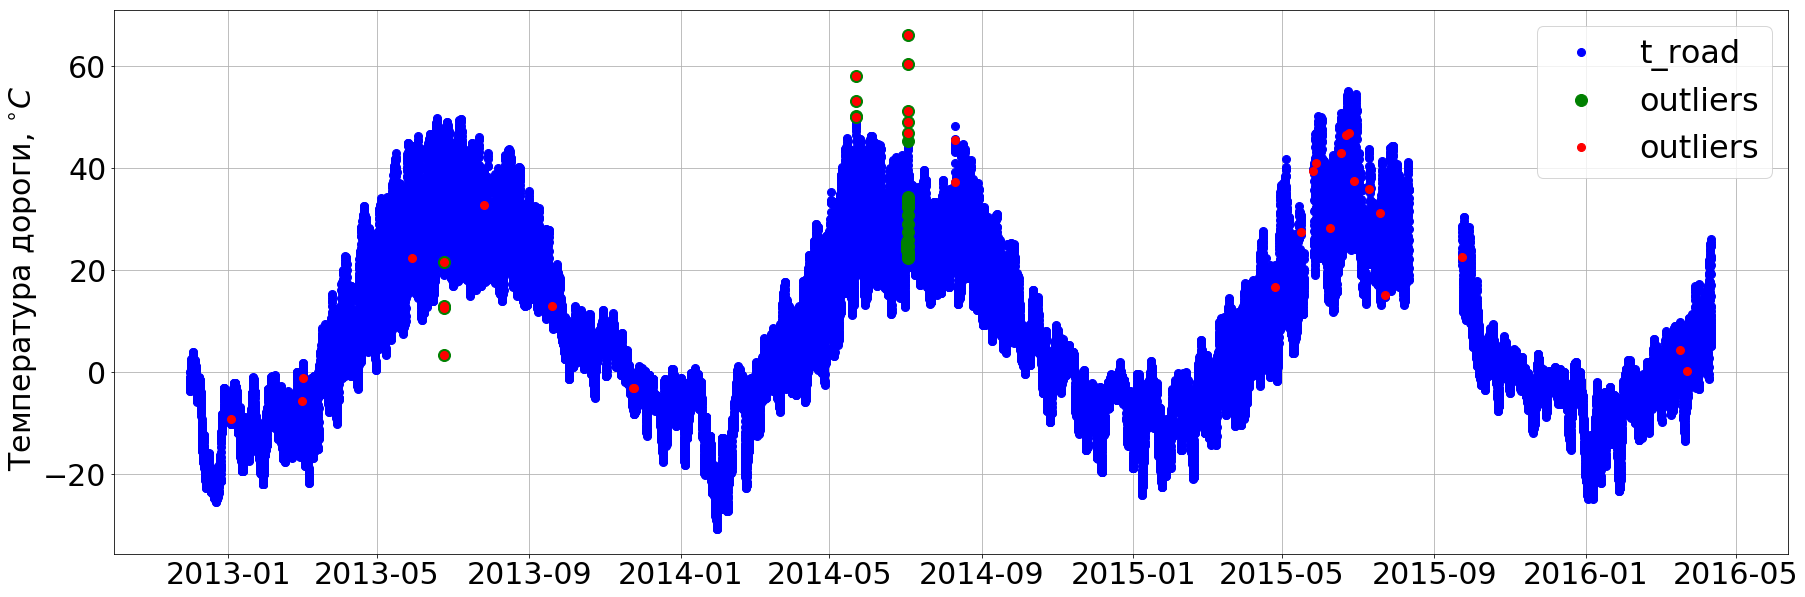

In [28]:
import matplotlib.pyplot as plt

#st_id = [114, 117, 119, 442, 504, 511, 1838, 1896]
#303, 307!!, 393!!, 503, 516
#test_station_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]
z = copy(df_test[df_test['station_id']==114].set_index('date_time_utc'))

start = pd.Timestamp(2012, 12, 1)
end = pd.Timestamp(2017, 2, 1)

to_plot = z[(z.index<=end) & (z.index>=start)]

plt.figure(figsize=(30, 10))

for elem in [True, False]:
    cond_predict = (to_plot['label_predict'] == 0) == elem
    cond_true = (to_plot['label_true'] == 0) == elem
    
    if elem:
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_road'], 'b',
                      linestyle='none', marker='o', markersize=8, label='t_road')
    else:
        
        plt.plot_date(to_plot[cond_true].index, to_plot[cond_true]['target_t_road'], 'g.',
                              linestyle='none', marker='o', label='outliers', markersize=12)
        
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_road'], 'r.',
                              linestyle='none', marker='o', label='outliers', markersize=8)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Температура дороги, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)
plt.show()